# Test the fine tuned model

In [283]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from ase.io import read
from ase.data import chemical_symbols
from ase.atoms import Atoms
import copy
import numpy as np
import pandas as pd
from scipy.constants import physical_constants
HARTREE_TO_EV = physical_constants['Hartree energy in eV'][0]
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

import matplotlib.pyplot as plt

import sys
import os
import json
import re
import shutil as sh

from janus_core.calculations.single_point import SinglePoint
from janus_core.calculations.geom_opt import GeomOpt

current_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(current_dir)

from structure_generation import get_all_configurations_pmg, write_extended_xyz, generate_random_structures, \
    write_CRYSTAL_gui_from_data

from local_functions import lattice_params_to_matrix, get_errors, get_rankings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Single point example

In [183]:
ase_structure = read('data/crystal/test_files/test_concatenated.xyz', index=":")
sp_mace = SinglePoint(
    struct=ase_structure.copy(),
    arch="mace_mp",
    device="cpu",
    model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/fine_tuned/1000/AlGaN-medium-mpa-0.model",
    calc_kwargs={"default_dtype": "float64"},
    properties="forces",
)

init_energy = sp_mace.run()["forces"]
print(init_energy)

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
[array([[ 1.32459994e-03, -1.48750722e-02, -1.51784163e-02],
       [-1.62603006e-03, -1.57903813e-02, -6.54356767e-03],
       [-1.54805864e-03, -1.43182899e-02, -1.11621269e-02],
       [-6.38166025e-04, -1.37716244e-04, -1.30855322e-02],
       [-3.36317466e-03, -1.34460386e-03, -6.35208477e-03],
       [-5.02897851e-03, -2.64575913e-03, -5.76977292e-03],
       [-5.38142339e-04,  1.76508833e-03, -1.53680000e-02],
       [-3.18445416e-03,  1.41358462e-03, -8.61578277e-03],
       [-4.53644027e-03,  8.78767142e-04, -1.06914401e-02],
       [ 1.72615042e-03, -1.40960185e-02, -1.26675277e-02],
       [ 3.44835364e-03, -1.37695009e-02, -4.93970314e-03],
       [ 5.63045234e-03, -1.20040975e-02, -6.64229350e-03],
       [-9.93080750e-04, -4.83744418e-04, -1.14909692e-02],
       [ 9.37801359e-04, -4.18208402e-04, -5.01251492e-03],
       [ 3.11856403e-03, -1.53191895e-03, -3.445685

In [221]:
for atom in ['Al','Ga','N']:

    ase_structure = Atoms(atom,[[0.0, 0.0, 0.0]])
    sp_mace = SinglePoint(
        struct=ase_structure.copy(),
        arch="mace_mp",
        device="cpu",
        #model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/fine_tuned/100000/AlGaN-medium-mpa-0.model",
        model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/fine_tuned/pbe0/AlGaN-medium-mpa-0.model",
        
        calc_kwargs={"default_dtype": "float64"},
        properties="energy",
    )

    init_energy = sp_mace.run()["energy"]
    print(atom,init_energy)

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Al -6588.9893025379115
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Ga -52368.31292725739
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
N -1484.0368955349575


### Geometry optimisation example

In [71]:
ase_structure = read('data/crystal/AlGaN/super3/extxyz_files/AlGaN_super3_1_0_0.xyz')
optimized_structure = GeomOpt(
    struct=ase_structure.copy(),
    arch="mace_mp",
    device="cpu",
    model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/fine_tuned/1000/AlGaN-medium-mpa-0.model",
    calc_kwargs={"default_dtype": "float64"},
    fmax=0.001,
    filter_kwargs={"hydrostatic_strain": True},
)
optimized_structure.run()

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
       Step     Time          Energy          fmax
LBFGS:    0 09:56:00  -482438.097942        0.367193
LBFGS:    1 09:56:03  -482438.104185        0.365492
LBFGS:    2 09:56:05  -482438.320745        0.300169
LBFGS:    3 09:56:07  -482438.494879        0.234136
LBFGS:    4 09:56:09  -482438.625663        0.167811
LBFGS:    5 09:56:13  -482438.712262        0.101658
LBFGS:    6 09:56:15  -482438.754157        0.036178
LBFGS:    7 09:56:16  -482438.758754        0.036774
LBFGS:    8 09:56:18  -482438.759265        0.036580
LBFGS:    9 09:56:20  -482438.769696        0.027719
LBFGS:   10 09:56:22  -482438.777062        0.025785
LBFGS:   11 09:56:24  -482438.781904        0.018055
LBFGS:   12 09:56:25  -482438.782775        0.013042
LBFGS:   13 09:56:27  -482438.782919        0.013305
LBFGS:   14 09:56:29  -482438.783074        0.013233
LBFGS:   15 09:56:31  -482438.783564        0.

# Compare energies DFT/MACE 

In [328]:
al_dft_energy = -6.589117430582E+03
ga_dft_energy = -5.236806134899E+04
n_dft_energy = -1.483705316803E+03

num_sites = 54 # there are 54 anion and 54 cation sites
num_atoms = 108 # there are 54 anion and 54 cation sites

## mace-mpa-0-medium.model

In [148]:
al_mace_energy = -0.21630193
ga_mace_energy = -0.32990651
n_mace_energy = -3.12438806

### Test set only

In [149]:
energies = np.loadtxt("data/fine_tuning/pt_model/energies_test.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_sites-num_al) + n_dft_energy*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

### Errors

In [150]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 2.785e+00
RMSE: 1.669e+00
Percentage MSE: 1.934e+00 %
Max Absolute Error: 1.995e+00
Max Percentage Error: 1.479e+01 %


### Ranking

These are calculated over the whole range, so it doesn't capture the fine details of the ranking within a fixed composition.

In [151]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.99978
Kendall's Tau: 0.99266


### The whole set (including training)

In [152]:
energies = np.loadtxt("data/fine_tuning/pt_model/energies_all.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_sites-num_al) + n_dft_energy*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

In [108]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 2.826e+00
RMSE: 1.681e+00
Percentage MSE: 1.944e+00 %
Max Absolute Error: 1.995e+00
Max Percentage Error: 1.484e+01 %


In [153]:
for i in range(1,54):
    index = np.where(num_al == i)[0]
    print(i,len(index))
    get_rankings(dft_energies_form[index],mace_energies_form[index])

1 18
Spearman's Rank Correlation: 0.83075
Kendall's Tau: 0.75163
2 48
Spearman's Rank Correlation: 0.96154
Kendall's Tau: 0.8735
3 54
Spearman's Rank Correlation: 0.95204
Kendall's Tau: 0.86734
4 49
Spearman's Rank Correlation: 0.98232
Kendall's Tau: 0.91869
5 46
Spearman's Rank Correlation: 0.9745
Kendall's Tau: 0.89899
6 51
Spearman's Rank Correlation: 0.86658
Kendall's Tau: 0.71507
7 48
Spearman's Rank Correlation: 0.96455
Kendall's Tau: 0.86906
8 49
Spearman's Rank Correlation: 0.97653
Kendall's Tau: 0.8834
9 51
Spearman's Rank Correlation: 0.8654
Kendall's Tau: 0.73284
10 52
Spearman's Rank Correlation: 0.9739
Kendall's Tau: 0.88495
11 51
Spearman's Rank Correlation: 0.94536
Kendall's Tau: 0.82639
12 74
Spearman's Rank Correlation: 0.9803
Kendall's Tau: 0.93044
13 48
Spearman's Rank Correlation: 0.97074
Kendall's Tau: 0.89996
14 45
Spearman's Rank Correlation: 0.97628
Kendall's Tau: 0.89495
15 49
Spearman's Rank Correlation: 0.95819
Kendall's Tau: 0.85653
16 48
Spearman's Rank Cor

### Parity plot

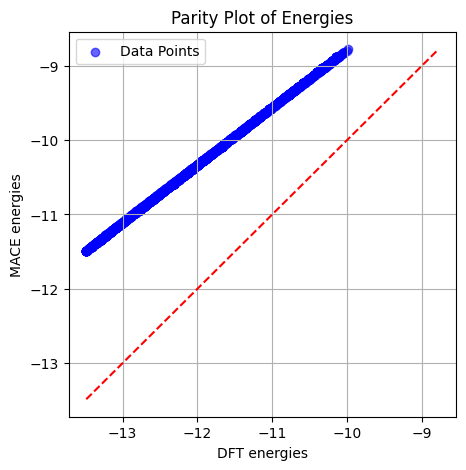

In [154]:
# Create the parity plot
plt.figure(figsize=(5,5))
plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Residual Plot of Energies

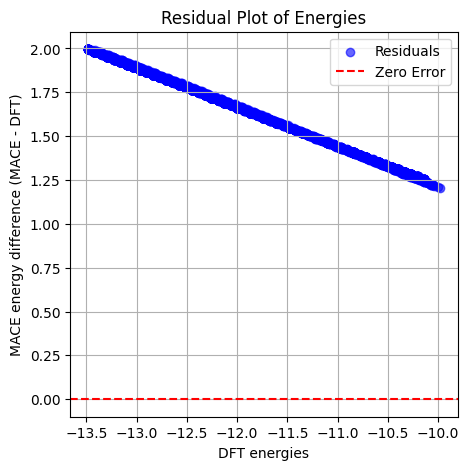

In [155]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

## ft - 1000

In [317]:
al_mace_energy = -6589.117430582
ga_mace_energy = -52368.06134899
n_mace_energy = -1483.705316803

### Test set only

In [318]:
json_file = "data/fine_tuning/1000/sp_forces_stress.json"
with open(json_file, 'r') as f:
    data = json.load(f)
num_samples = len(data)

In [320]:
import numpy as np

def extract_data_from_dict(data):
    """
    Extracts structured data from a dictionary of DFT/MACE results and returns NumPy arrays.

    Parameters:
        data (dict): Dictionary with string keys ("0", "1", ...) each mapping to a dict of properties.

    Returns:
        tuple of np.ndarray: (
            num_al        (shape: [N]),
            dft_energies  (shape: [N]),
            mace_energies (shape: [N]),
            dft_forces    (shape: [N, n_atoms, 3]),
            mace_forces   (shape: [N, n_atoms, 3]),
            dft_stress    (shape: [N, 3, 3]),
            mace_stress   (shape: [N, 3, 3])
        )
    """
    num_al = []
    dft_energies = []
    mace_energies = []
    dft_forces = []
    mace_forces = []
    dft_stress = []
    mace_stress = []

    num_samples = len(data)

    for i in range(num_samples):
        entry = data[str(i)]

        # Optional field
        # num_al.append(entry.get('num_al', 0))

        # Scalars
        dft_energies.append(entry['dft_energy'])
        mace_energies.append(entry['mace_energy'])

        # Arrays
        dft_forces.append(np.array(entry['dft_forces']))
        mace_forces.append(np.array(entry['mace_forces']))
        dft_stress.append(parse_dft_stress(entry['dft_stress']))
        mace_stress.append(parse_mace_stress(entry['mace_stress']))

    return (
        np.array(num_al),
        np.array(dft_energies),
        np.array(mace_energies),
        np.array(dft_forces),
        np.array(mace_forces),
        np.array(dft_stress),
        np.array(mace_stress)
    )

In [321]:
num_al, dft_energies, mace_energies, dft_forces, mace_forces, dft_stress, mace_stress = extract_data_from_dict(data)

In [332]:
energies = np.loadtxt("data/fine_tuning/1000/energies_test.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_atoms-num_al) + n_dft_energy*num_atoms))/num_atoms

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_atoms-num_al) + n_mace_energy*num_atoms))/num_atoms

In [334]:
import numpy as np
from sklearn.metrics import root_mean_squared_error

def get_errors(dft_energies_form, mace_energies_form, 
               dft_forces=None, mace_forces=None,
               dft_stress=None, mace_stress=None,
               sig_figs=3, return_errors=False):
    """
    Compute and print RMSE and %RMSE for energy, forces, and stress.

    All RMSE values are reported in meV. Percentage RMSEs are unitless.

    Parameters:
        dft_energies_form (np.ndarray): DFT formation energies
        mace_energies_form (np.ndarray): MACE formation energies
        dft_forces (np.ndarray): Optional list or array of DFT forces (N, atoms, 3)
        mace_forces (np.ndarray): Optional list or array of MACE forces (N, atoms, 3)
        dft_stress (np.ndarray): Optional array of DFT stresses (N, 3, 3)
        mace_stress (np.ndarray): Optional array of MACE stresses (N, 3, 3)
        sig_figs (int): Significant figures for printing
        return_errors (bool): If True, return errors as dictionary

    Returns:
        dict (optional): Errors if return_errors=True
    """
    def sci_notation(value, sig_figs):
        return f"{value:.{sig_figs}e}"

    errors = {}

    # --- Energy Errors ---
    energy_rmse = root_mean_squared_error(dft_energies_form, mace_energies_form)
    mean_ref_energy = np.mean(np.abs(dft_energies_form))
    energy_pct_rmse = 100 * energy_rmse / mean_ref_energy if mean_ref_energy > 0 else np.nan

    energy_rmse_meV = energy_rmse * 1000

    print("Energy Errors:")
    print("RMSE:", sci_notation(energy_rmse_meV, sig_figs), "meV")
    print("%RMSE:", sci_notation(energy_pct_rmse, sig_figs), "%")

    errors.update({
        "energy_rmse_meV": energy_rmse_meV,
        "energy_pct_rmse": energy_pct_rmse
    })

    # --- Force Errors ---
    if dft_forces is not None and mace_forces is not None:
        ref_flat = np.concatenate(dft_forces, axis=0).ravel()
        pred_flat = np.concatenate(mace_forces, axis=0).ravel()

        force_rmse = root_mean_squared_error(ref_flat, pred_flat)
        mean_ref_force = np.mean(np.abs(ref_flat))
        force_pct_rmse = 100 * force_rmse / mean_ref_force if mean_ref_force > 0 else np.nan

        force_rmse_meV = force_rmse * 1000

        print("\nForce Errors:")
        print("RMSE:", sci_notation(force_rmse_meV, sig_figs), "meV/Å")
        print("%RMSE:", sci_notation(force_pct_rmse, sig_figs), "%")

        errors.update({
            "force_rmse_meV": force_rmse_meV,
            "force_pct_rmse": force_pct_rmse
        })

    # --- Stress Errors ---
    if dft_stress is not None and mace_stress is not None:
        dft_flat = np.reshape(dft_stress, (-1, 9))
        mace_flat = np.reshape(mace_stress, (-1, 9))

        stress_rmse = root_mean_squared_error(dft_flat, mace_flat)
        mean_ref_stress = np.mean(np.abs(dft_flat))
        stress_pct_rmse = 100 * stress_rmse / mean_ref_stress if mean_ref_stress > 0 else np.nan

        stress_rmse_meV = stress_rmse * 1000

        print("\nStress Errors:")
        print("RMSE:", sci_notation(stress_rmse_meV, sig_figs), "meV")
        print("%RMSE:", sci_notation(stress_pct_rmse, sig_figs), "%")

        errors.update({
            "stress_rmse_meV": stress_rmse_meV,
            "stress_pct_rmse": stress_pct_rmse
        })

    if return_errors:
        return errors

In [336]:
get_errors(dft_energies_form, mace_energies_form, 
               dft_forces, mace_forces,
               dft_stress, mace_stress,
               sig_figs=3, return_errors=True)

Energy Errors:
RMSE: 1.031e+01 meV
%RMSE: 3.830e-05 %

Force Errors:
RMSE: 1.954e+00 meV/Å
%RMSE: 1.640e+02 %

Stress Errors:
RMSE: 1.520e+00 meV
%RMSE: 8.645e+01 %


{'energy_rmse_meV': 10.311639414453916,
 'energy_pct_rmse': 3.830489332014505e-05,
 'force_rmse_meV': 1.953564743887727,
 'force_pct_rmse': 164.0127848435224,
 'stress_rmse_meV': 1.51987406844332,
 'stress_pct_rmse': 86.45350157291611}

### Errors

In [323]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 4.253e-04
RMSE: 2.062e-02
Percentage MSE: 2.954e-04 %
Max Absolute Error: 9.267e-02
Max Percentage Error: 7.753e-01 %


### Ranking

These are calculated over the whole range, so it doesn't capture the fine details of the ranking within a fixed composition.

In [187]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.99967
Kendall's Tau: 0.98915


### The whole set (including training)

In [188]:
energies = np.loadtxt("data/fine_tuning/1000/energies_all.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_sites-num_al) + n_dft_energy*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

In [162]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 4.708e-04
RMSE: 2.170e-02
Percentage MSE: 3.238e-04 %
Max Absolute Error: 9.826e-02
Max Percentage Error: 8.327e-01 %


In [209]:
for i in range(1,54):
    index = np.where(num_al == i)[0]
    print(f'Conc: {round(i/num_sites,3)}',f'num structures: {len(index)}')
    get_rankings(dft_energies_form[index],mace_energies_form[index], print_coeff=True)
    print()

Conc: 0.019 num structures: 18
Spearman's Rank Correlation: 0.8225
Kendall's Tau: 0.71242

Conc: 0.037 num structures: 48
Spearman's Rank Correlation: 0.93294
Kendall's Tau: 0.79272

Conc: 0.056 num structures: 54
Spearman's Rank Correlation: 0.78791
Kendall's Tau: 0.63217

Conc: 0.074 num structures: 49
Spearman's Rank Correlation: 0.83448
Kendall's Tau: 0.68936

Conc: 0.093 num structures: 46
Spearman's Rank Correlation: 0.93179
Kendall's Tau: 0.7882

Conc: 0.111 num structures: 51
Spearman's Rank Correlation: 0.78616
Kendall's Tau: 0.64808

Conc: 0.13 num structures: 48
Spearman's Rank Correlation: 0.961
Kendall's Tau: 0.84472

Conc: 0.148 num structures: 49
Spearman's Rank Correlation: 0.89581
Kendall's Tau: 0.72061

Conc: 0.167 num structures: 51
Spearman's Rank Correlation: 0.91085
Kendall's Tau: 0.77407

Conc: 0.185 num structures: 52
Spearman's Rank Correlation: 0.91945
Kendall's Tau: 0.78792

Conc: 0.204 num structures: 51
Spearman's Rank Correlation: 0.65847
Kendall's Tau: 0.

In [217]:
all_spearman = np.zeros(54)
for i in range(1,54):
    index = np.where(num_al == i)[0]
    all_spearman[i] = get_rankings(np.round(dft_energies_form[index],3),
                                   np.round(mace_energies_form[index],3), print_coeff=False)[1]

In [219]:
np.sort(all_spearman)

array([-0.3415813 ,  0.        ,  0.05725696,  0.16133422,  0.29774955,
        0.39975207,  0.42559356,  0.43488869,  0.44396082,  0.45942724,
        0.47132912,  0.52238873,  0.52636884,  0.57879998,  0.58768579,
        0.61372472,  0.63666973,  0.64120222,  0.64587418,  0.64612362,
        0.64867864,  0.64963643,  0.6675689 ,  0.67229672,  0.67458393,
        0.67490923,  0.68716827,  0.68878485,  0.69278286,  0.71610843,
        0.73098142,  0.73542195,  0.73574451,  0.74922682,  0.75191633,
        0.75241028,  0.75910707,  0.78047015,  0.78333256,  0.79735438,
        0.79765883,  0.79949106,  0.8126977 ,  0.81489254,  0.81840209,
        0.82495775,  0.83030519,  0.83615676,  0.85159165,  0.86014557,
        0.86928565,  0.87001305,  0.8993045 ,  0.90878495])

In [206]:
index = np.where(num_al == 39)[0]
#print(dft_energies_form[index]-mace_energies_form[index])
print(np.sort(np.round(dft_energies_form[index],4)))
print(np.sort(np.round(mace_energies_form[index],4)))

[-12.5802 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801
 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801
 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801
 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801
 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801 -12.5801
 -12.58   -12.58   -12.58   -12.58   -12.58   -12.58   -12.58   -12.58
 -12.58   -12.58   -12.58   -12.58   -12.58   -12.58   -12.58   -12.5799
 -12.5799 -12.5799 -12.5797 -12.5797 -12.5796 -12.5795 -12.5795 -12.5795
 -12.5794 -12.5793 -12.5793 -12.5793 -12.5793 -12.5793 -12.5793 -12.5793
 -12.5793 -12.5793 -12.5792 -12.5792 -12.5792 -12.5792 -12.579  -12.5789
 -12.5789 -12.5788 -12.5784 -12.5781 -12.5778 -12.5778 -12.5778 -12.5777
 -12.5777 -12.5777 -12.5777 -12.5777 -12.5777 -12.5777 -12.5777 -12.5777
 -12.5777 -12.5777 -12.5776 -12.5776 -12.5776 -12.5773 -12.5773 -12.5772
 -12.5769 -12.5764 -12.5764 -12.5762 -12.5758 -12.574

### Parity plot

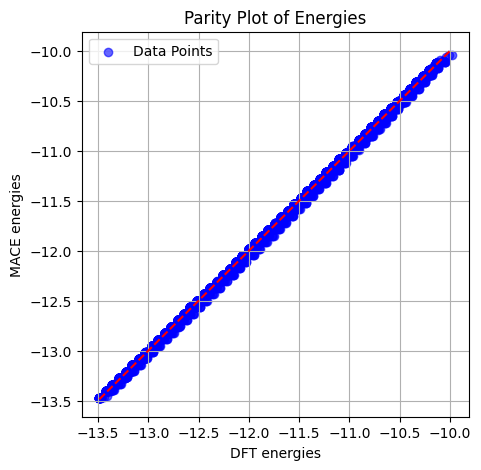

In [118]:
# Create the parity plot
plt.figure(figsize=(5,5))
plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Residual Plot of Energies

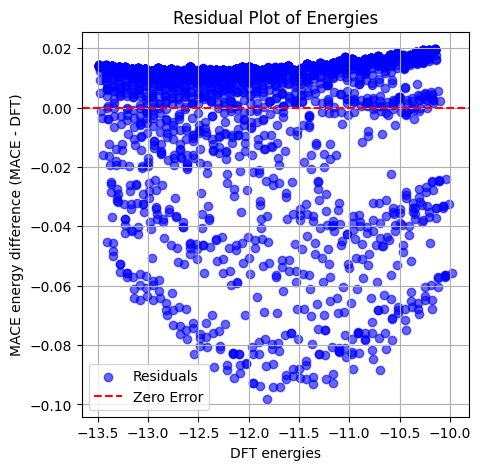

In [119]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

### Active learning

Energy

In [174]:
(np.sort(np.abs(dft_energies_form-mace_energies_form))/-dft_energies_form)*100

array([0.02034096, 0.02701845, 0.03966119, 0.05334697, 0.05352412,
       0.05681335, 0.07317148, 0.06260051, 0.06785643, 0.07365594,
       0.08858707, 0.07628399, 0.09205472, 0.08471855, 0.10191672,
       0.10213834, 0.10295775, 0.10428489, 0.08730949, 0.10534621,
       0.10691693, 0.0895764 , 0.09023022, 0.09033802, 0.10974347,
       0.10981597, 0.11051307, 0.11060386, 0.11077279, 0.11165869,
       0.09274622, 0.09345016, 0.1136067 , 0.11427188, 0.11457188,
       0.11552363, 0.09500726, 0.11729482, 0.09607445, 0.09621757,
       0.11853688, 0.11858809, 0.11895022, 0.1192148 , 0.09763889,
       0.09767307, 0.09346598, 0.09859231, 0.09425972, 0.09507253,
       0.12489232, 0.10160617, 0.12527657, 0.12528313, 0.10273902,
       0.10245423, 0.12706257, 0.12967065, 0.10377067, 0.12941561,
       0.10470577, 0.12999492, 0.12996948, 0.13117216, 0.10606312,
       0.13408408, 0.13210656, 0.10683023, 0.13407608, 0.10291657,
       0.10363564, 0.10844552, 0.10905444, 0.10417198, 0.10421

Forces

In [ ]:
(np.sort(np.abs(dft_energies_form-mace_energies_form))/-dft_energies_form)*100

array([0.02034096, 0.02701845, 0.03966119, 0.05334697, 0.05352412,
       0.05681335, 0.07317148, 0.06260051, 0.06785643, 0.07365594,
       0.08858707, 0.07628399, 0.09205472, 0.08471855, 0.10191672,
       0.10213834, 0.10295775, 0.10428489, 0.08730949, 0.10534621,
       0.10691693, 0.0895764 , 0.09023022, 0.09033802, 0.10974347,
       0.10981597, 0.11051307, 0.11060386, 0.11077279, 0.11165869,
       0.09274622, 0.09345016, 0.1136067 , 0.11427188, 0.11457188,
       0.11552363, 0.09500726, 0.11729482, 0.09607445, 0.09621757,
       0.11853688, 0.11858809, 0.11895022, 0.1192148 , 0.09763889,
       0.09767307, 0.09346598, 0.09859231, 0.09425972, 0.09507253,
       0.12489232, 0.10160617, 0.12527657, 0.12528313, 0.10273902,
       0.10245423, 0.12706257, 0.12967065, 0.10377067, 0.12941561,
       0.10470577, 0.12999492, 0.12996948, 0.13117216, 0.10606312,
       0.13408408, 0.13210656, 0.10683023, 0.13407608, 0.10291657,
       0.10363564, 0.10844552, 0.10905444, 0.10417198, 0.10421

## ft - 10000

In [91]:
al_mace_energy = -6589.117430582
ga_mace_energy = -52368.06134899
n_mace_energy = -1483.705316803


### Test set only

In [92]:
energies = np.loadtxt("data/fine_tuning/10000/energies_test.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_sites-num_al) + n_dft_energy*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

### Errors

In [93]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 4.618e-04
RMSE: 2.149e-02
Percentage MSE: 3.207e-04 %
Max Absolute Error: 9.063e-02
Max Percentage Error: 7.583e-01 %


### Ranking

These are calculated over the whole range, so it doesn't capture the fine details of the ranking within a fixed composition.

In [94]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.99966
Kendall's Tau: 0.98814


### The whole set (including training)

In [95]:
energies = np.loadtxt("data/fine_tuning/10000/energies_all.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_sites-num_al) + n_dft_energy*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

In [96]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 5.051e-04
RMSE: 2.248e-02
Percentage MSE: 3.474e-04 %
Max Absolute Error: 9.646e-02
Max Percentage Error: 8.533e-01 %


In [97]:
for i in range(1,54):
    index = np.where(num_al == i)[0]
    print(i,len(index))
    get_rankings(dft_energies_form[index],mace_energies_form[index])

1 18
Spearman's Rank Correlation: 0.73722
Kendall's Tau: 0.59017
2 48
Spearman's Rank Correlation: 0.65818
Kendall's Tau: 0.51954
3 54
Spearman's Rank Correlation: 0.56576
Kendall's Tau: 0.42337
4 49
Spearman's Rank Correlation: 0.55568
Kendall's Tau: 0.37856
5 46
Spearman's Rank Correlation: 0.72082
Kendall's Tau: 0.56507
6 51
Spearman's Rank Correlation: 0.78178
Kendall's Tau: 0.65462
7 48
Spearman's Rank Correlation: 0.83887
Kendall's Tau: 0.70129
8 49
Spearman's Rank Correlation: 0.85297
Kendall's Tau: 0.70473
9 51
Spearman's Rank Correlation: 0.48142
Kendall's Tau: 0.31513
10 52
Spearman's Rank Correlation: 0.84501
Kendall's Tau: 0.72254
11 51
Spearman's Rank Correlation: 0.58148
Kendall's Tau: 0.39843
12 74
Spearman's Rank Correlation: 0.78211
Kendall's Tau: 0.62437
13 48
Spearman's Rank Correlation: 0.59546
Kendall's Tau: 0.45471
14 45
Spearman's Rank Correlation: 0.78112
Kendall's Tau: 0.65993
15 49
Spearman's Rank Correlation: 0.67912
Kendall's Tau: 0.51915
16 48
Spearman's Ra

### Parity plot

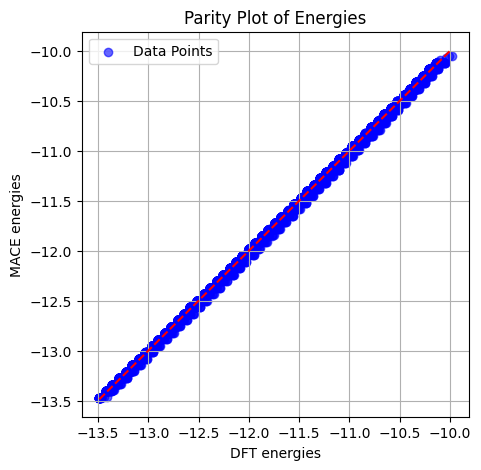

In [98]:
# Create the parity plot
plt.figure(figsize=(5,5))
plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Residual Plot of Energies

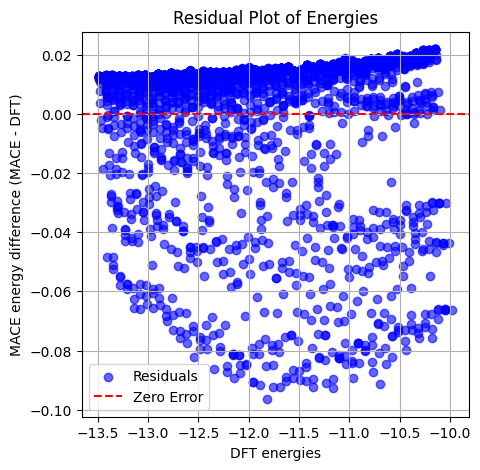

In [99]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

## ft - 100000

In [100]:
al_mace_energy = -6589.117430582
ga_mace_energy = -52368.06134899
n_mace_energy = -1483.705316803

### Test set only

In [164]:
energies = np.loadtxt("data/fine_tuning/100000/energies_test.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_sites-num_al) + n_dft_energy*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

### Errors

In [165]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 5.225e-04
RMSE: 2.286e-02
Percentage MSE: 3.629e-04 %
Max Absolute Error: 9.548e-02
Max Percentage Error: 9.500e-01 %


### Ranking

These are calculated over the whole range, so it doesn't capture the fine details of the ranking within a fixed composition.

In [126]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.99943
Kendall's Tau: 0.98201


### The whole set (including training)

In [127]:
energies = np.loadtxt("data/fine_tuning/100000/energies_all.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_sites-num_al) + n_dft_energy*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

In [128]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 5.974e-04
RMSE: 2.444e-02
Percentage MSE: 4.109e-04 %
Max Absolute Error: 1.064e-01
Max Percentage Error: 1.000e+00 %


In [ ]:
for i in range(1,54):
    index = np.where(num_al == i)[0]
    print(i,len(index))
    get_rankings(dft_energies_form[index],mace_energies_form[index])

1 18
Spearman's Rank Correlation: 0.83075
Kendall's Tau: 0.75163
2 48
Spearman's Rank Correlation: 0.96154
Kendall's Tau: 0.8735
3 54
Spearman's Rank Correlation: 0.95204
Kendall's Tau: 0.86734
4 49
Spearman's Rank Correlation: 0.98232
Kendall's Tau: 0.91869
5 46
Spearman's Rank Correlation: 0.9745
Kendall's Tau: 0.89899
6 51
Spearman's Rank Correlation: 0.86658
Kendall's Tau: 0.71507
7 48
Spearman's Rank Correlation: 0.96455
Kendall's Tau: 0.86906
8 49
Spearman's Rank Correlation: 0.97653
Kendall's Tau: 0.8834
9 51
Spearman's Rank Correlation: 0.8654
Kendall's Tau: 0.73284
10 52
Spearman's Rank Correlation: 0.9739
Kendall's Tau: 0.88495
11 51
Spearman's Rank Correlation: 0.94536
Kendall's Tau: 0.82639
12 74
Spearman's Rank Correlation: 0.9803
Kendall's Tau: 0.93044
13 48
Spearman's Rank Correlation: 0.97074
Kendall's Tau: 0.89996
14 45
Spearman's Rank Correlation: 0.97628
Kendall's Tau: 0.89495
15 49
Spearman's Rank Correlation: 0.95819
Kendall's Tau: 0.85653
16 48
Spearman's Rank Cor

### Parity plot

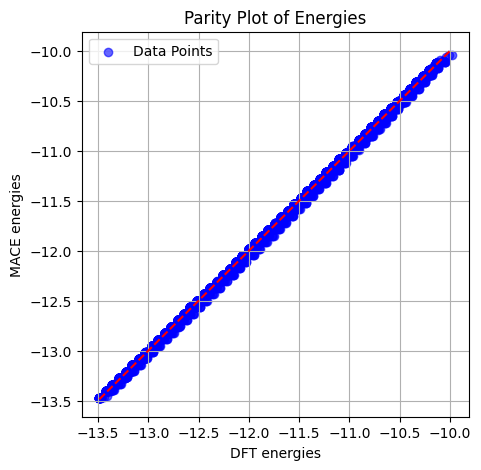

In [ ]:
# Create the parity plot
plt.figure(figsize=(5,5))
plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Residual Plot of Energies

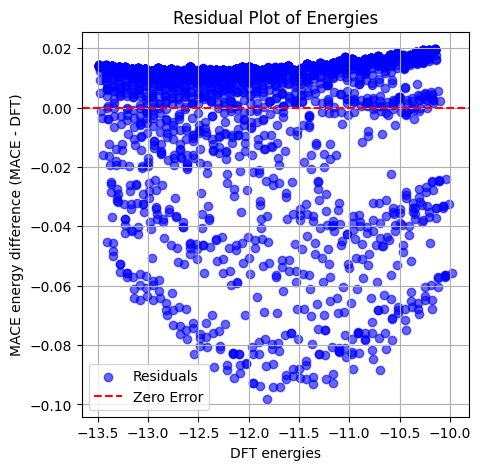

In [ ]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

# Simulated annealing 
On the ft - 1000 model

In [ ]:
al_mace_energy = -6589.117430582
ga_mace_energy = -52368.06134899
n_mace_energy = -1483.705316803

In [138]:
energies = np.genfromtxt('data/fine_tuning/1000/sa/sa_energies.csv',delimiter=",")[1:,1]

# Extract the two columns separately
mace_energies = energies  # Second column
num_al = 27

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

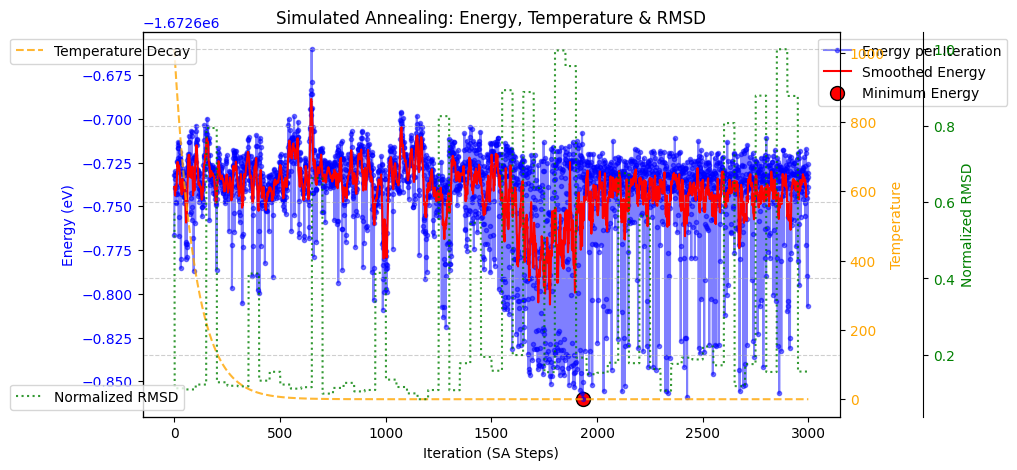

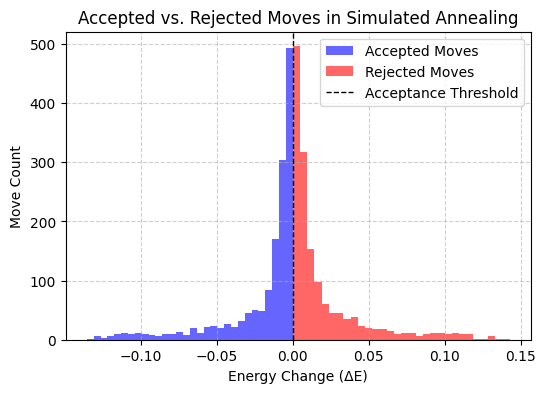

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load data from the SA energy output file
data = np.genfromtxt("data/fine_tuning/1000/sa/sa_energies.csv", delimiter=",", skip_header=1)  # Skip header row
data = np.genfromtxt("data/fine_tuning/1000/sa/temperature/sa_energies_10000.csv", delimiter=",", skip_header=1)  # Skip header row
steps = data[:, 0]  # Iteration (SA steps)
energies = data[:, 1]  # Energy values
rmsd_values = data[:, 2]  # RMSD values

# Define SA parameters (to reconstruct temperature schedule)
T_init = 1000  # Initial temperature
cooling_rate = 0.99
temperatures = T_init * (cooling_rate ** steps)  # Compute temperature decay

# Compute Smoothed Energy (Rolling Average)
smoothed_energy = uniform_filter1d(energies, size=10)  # Moving average window = 10

# Compute acceptance rates (approximate)
delta_energies = np.diff(energies)  # Change in energy at each step
accepted_moves = delta_energies < 0  # Moves accepted when energy decreases
rejected_moves = delta_energies >= 0  # Moves rejected when energy increases

# Create figure
fig, ax1 = plt.subplots(figsize=(9,5))

# Plot energy per iteration
ax1.plot(steps, energies, 'o-', markersize=3, alpha=0.5, label="Energy per Iteration", color="blue")
ax1.plot(steps[:-9], smoothed_energy[:-9], color='red', linewidth=1.5, label="Smoothed Energy")  # Overlay smoothed energy trend

# Highlight the minimum energy found
min_energy_idx = np.argmin(energies)
ax1.scatter(steps[min_energy_idx], energies[min_energy_idx], color='red', s=100, edgecolor='black', label="Minimum Energy")

ax1.set_xlabel("Iteration (SA Steps)")
ax1.set_ylabel("Energy (eV)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_title("Simulated Annealing: Energy, Temperature & RMSD")

# Add secondary y-axis for temperature decay
ax2 = ax1.twinx()
ax2.plot(steps, temperatures, '--', color="orange", alpha=0.8, label="Temperature Decay")
ax2.set_ylabel("Temperature", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# Adjust RMSD scaling (normalize)
rmsd_normalized = rmsd_values / np.max(rmsd_values)  # Normalize RMSD to [0,1]
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Shift third axis
ax3.plot(steps, rmsd_normalized, ':', color="green", alpha=0.8, label="Normalized RMSD")
ax3.set_ylabel("Normalized RMSD", color="green")
ax3.tick_params(axis='y', labelcolor="green")

# Adjust legend positions
ax1.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
ax2.legend(loc="upper left", bbox_to_anchor=(-0.2, 1))
ax3.legend(loc="lower left", bbox_to_anchor=(-0.2, 0))

plt.grid(True, linestyle="--", alpha=0.6)

# Show combined SA plot
plt.show()

# --------------------
# Histogram: Accepted vs. Rejected Moves
# --------------------
plt.figure(figsize=(6,4))
plt.hist(delta_energies[accepted_moves], bins=30, alpha=0.6, color="blue", label="Accepted Moves")
plt.hist(delta_energies[rejected_moves], bins=30, alpha=0.6, color="red", label="Rejected Moves")

plt.axvline(0, color="black", linestyle="--", linewidth=1, label="Acceptance Threshold")

plt.xlabel("Energy Change (ΔE)")
plt.ylabel("Move Count")
plt.title("Accepted vs. Rejected Moves in Simulated Annealing")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show histogram
plt.show()

In [ ]:
for i,index in enumerate(low_ten_index):
    file_name = f'data/fine_tuning/1000/sa/dft/AlGaN_sa_{i}.gui'
    sh.copy('data/fine_tuning/1000/sa/dft/AlGaN_sa_input.d12',
            f'data/fine_tuning/1000/sa/dft/AlGaN_sa_{i}.d12')
    structure = ase_all_structures[index]
    lattice = structure.get_cell()
    coords = structure.get_positions()
    atomic_numbers = structure.get_atomic_numbers()
    write_CRYSTAL_gui_from_data(lattice,atomic_numbers,coords,file_name,dimensionality=3)
    print(f'timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_{i} &')
print('wait')

timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_0 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_1 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_2 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_3 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_4 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_5 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_6 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_7 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_8 &
timeout 1430m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi AlGaN_sa_9 &
wait


# PBE0

In [233]:
al_dft_energy_pbe0 = -2.4214089069091E+02*HARTREE_TO_EV
ga_dft_energy_pbe0 = -1.9245000035593E+03*HARTREE_TO_EV
n_dft_energy_pbe0 = -5.4537349994573E+01*HARTREE_TO_EV

num_sites = 54 # there are 54 anion and 54 cation sites

In [234]:
al_mace_energy = -6588.9893025379115
ga_mace_energy = -52368.31292725739
n_mace_energy = -1484.0368955349575


### Test set only

In [257]:
energies = np.loadtxt("data/fine_tuning/pbe0/energies.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy_pbe0*num_al + 
                                    ga_dft_energy_pbe0*(num_sites-num_al) + n_dft_energy_pbe0*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

### Errors

In [258]:
get_errors(dft_energies_form, mace_energies_form)

MSE: 7.564e-04
RMSE: 2.750e-02
Percentage MSE: 5.003e-04 %
Max Absolute Error: 9.267e-02
Max Percentage Error: 7.510e-01 %


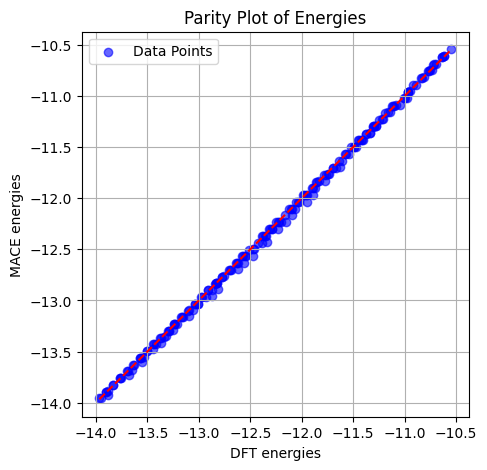

In [259]:
# Create the parity plot
plt.figure(figsize=(5,5))
plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

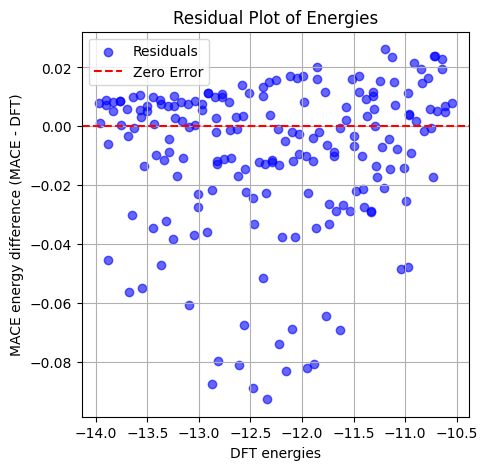

In [260]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

### Ranking

These are calculated over the whole range, so it doesn't capture the fine details of the ranking within a fixed composition.

In [246]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.99981
Kendall's Tau: 0.99265


### The whole set (including training)

In [261]:
energies = np.loadtxt("data/fine_tuning/pbe0/energies_all.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy_pbe0*num_al + 
                                    ga_dft_energy_pbe0*(num_sites-num_al) + n_dft_energy_pbe0*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

In [262]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 7.655e-01
RMSE: 8.749e-01
Percentage MSE: 5.594e-01 %
Max Absolute Error: 1.134e+00
Max Percentage Error: 1.206e+01 %


In [252]:
for i in range(1,54):
    index = np.where(num_al == i)[0]
    print(i,len(index))
    get_rankings(dft_energies_form[index],mace_energies_form[index])

1 18
Spearman's Rank Correlation: 0.30563
Kendall's Tau: 0.19672
2 48
Spearman's Rank Correlation: 0.51331
Kendall's Tau: 0.40693
3 54
Spearman's Rank Correlation: 0.42322
Kendall's Tau: 0.33392
4 49
Spearman's Rank Correlation: 0.39534
Kendall's Tau: 0.33291
5 46
Spearman's Rank Correlation: 0.43185
Kendall's Tau: 0.36267
6 51
Spearman's Rank Correlation: 0.12835
Kendall's Tau: 0.04088
7 48
Spearman's Rank Correlation: 0.47561
Kendall's Tau: 0.38489
8 49
Spearman's Rank Correlation: 0.03087
Kendall's Tau: 0.04176
9 51
Spearman's Rank Correlation: 0.20225
Kendall's Tau: 0.16509
10 52
Spearman's Rank Correlation: 0.09959
Kendall's Tau: 0.14943
11 51
Spearman's Rank Correlation: 0.02652
Kendall's Tau: -0.0173
12 74
Spearman's Rank Correlation: 0.33527
Kendall's Tau: 0.32532
13 48
Spearman's Rank Correlation: 0.109
Kendall's Tau: 0.12261
14 45
Spearman's Rank Correlation: -0.48159
Kendall's Tau: -0.21234
15 49
Spearman's Rank Correlation: -0.41591
Kendall's Tau: -0.13032
16 48
Spearman's 

### Parity plot

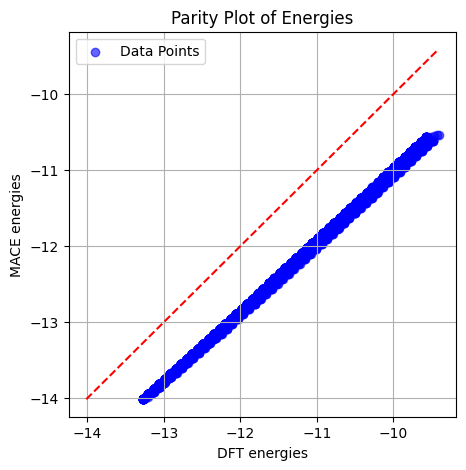

In [263]:
# Create the parity plot
plt.figure(figsize=(5,5))
plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Residual Plot of Energies

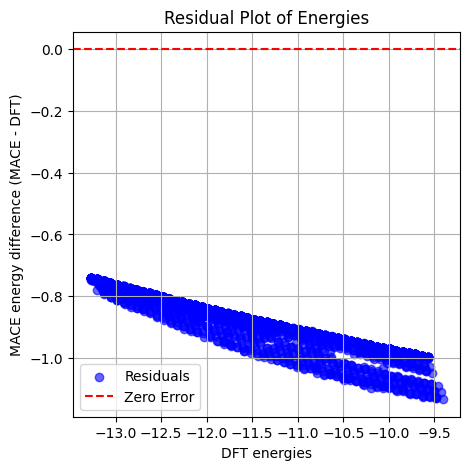

In [256]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

### Forces and stress

In [286]:
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

def compute_force_errors(forces_ref, forces_pred):
    """
    Compute RMSE and %MAPE between two lists of Nx3 force arrays using scikit-learn.
    
    Returns:
        tuple: (RMSE [eV/Å], %MAPE)
    """
    ref_flat = np.concatenate(forces_ref, axis=0).ravel()
    pred_flat = np.concatenate(forces_pred, axis=0).ravel()

    rmse = root_mean_squared_error(ref_flat, pred_flat)

    try:
        mape = mean_absolute_percentage_error(ref_flat, pred_flat) * 100
    except ValueError:
        mape = np.nan  # Handle divide-by-zero if any ref values are 0

    return rmse, mape

In [264]:
json_file = "data/fine_tuning/pbe0/forces_stress.json"
with open(json_file, 'r') as f:
    data = json.load(f)

In [292]:
for i in range(1000):
    if (compute_force_errors(np.array(data[f'{i}']['dft_forces']), np.array(data[f'{i}']['mace_forces']))[1]) < 10:
        print(i)

In [ ]:
# Atom-by-atom forces %
(np.array(data['0']['dft_forces'])-np.array(data['0']['mace_forces']))/np.array(data['0']['dft_forces'])

array([[ 1.39130682e+00,  2.13463779e-01, -3.45104808e-01],
       [ 1.80208237e+00,  2.08320968e-01, -1.83592902e-01],
       [-1.72717713e+00,  3.34109317e-03,  3.96631580e-01],
       [ 4.81381128e-02,  2.01467961e+00, -2.00417272e-01],
       [ 9.71259327e-01, -1.60045237e+00, -4.48944033e-01],
       [-6.98260502e-01,  2.52921166e+00, -1.33195845e-01],
       [ 1.76936260e+00,  6.08294497e-01,  6.70483835e-02],
       [ 1.36898536e-01,  1.37160751e+00, -6.95158755e-01],
       [ 1.28715172e-01, -2.03221980e+00, -3.45936058e-01],
       [-1.88821420e-01, -1.21446480e-01, -3.55283411e-01],
       [-2.02955664e+00,  1.41868664e-01,  6.75134020e-01],
       [-3.72679504e+00,  1.96977990e-01,  1.47653208e-01],
       [ 4.26753378e+00,  6.89762992e+00, -1.92955797e-01],
       [-1.18285162e+00, -5.41519209e+00,  7.98860265e-01],
       [ 4.24507276e+00,  1.05395037e+01,  2.62532135e+00],
       [-1.37631517e+00, -5.61379369e-01,  1.79511117e-02],
       [ 6.90956990e-01,  1.07549470e+00

In [274]:
# Sum forces 
for i in range(10):
    print(np.sum(np.abs(np.array(data[f'{i}']['dft_forces'])-np.array(data[f'{i}']['mace_forces'])))/(3*num_sites*2))

0.0024070654656998913
0.0021828770140185235
0.0016673889988974254
0.0016454154350433797
0.0016357120712901672
0.001630168401357427
0.001608536830683149
0.0015968233333788738
0.0015864369854825407
0.0015950597301106837
